In [17]:
import pandas as pd

df = pd.read_csv("data/OGNT_processed.csv")
df.head(8)

,Unnamed: 0,book,chapter,verse,word,lemma,trans,author
0,0,mt,1,1,Βιβλος,βίβλος,book,matthew
1,1,mt,1,1,γενεσεως,γένεσις,origin,matthew
2,2,mt,1,1,Ιησου,Ἰησοῦς,Jesus/Joshua,matthew
3,3,mt,1,1,Χριστου,Χριστός,Christ,matthew
4,4,mt,1,1,υιου,υἱός,son,matthew
5,5,mt,1,1,Δαυιδ,"Δαυείδ, Δαυίδ, Δαβίδ",David,matthew
6,6,mt,1,1,υιου,υἱός,son,matthew
7,7,mt,1,1,Αβρααμ,Ἀβραάμ,Abraham,matthew


In [2]:
import numpy as np

print(f"Words total: {len(df["word"])}")
print(f"Unique words: {len(np.unique(df["word"]))}")
print(f"Unique lemmas: {len(np.unique(df["lemma"]))}")

Words total: 138013
Unique words: 18310
Unique lemmas: 5395


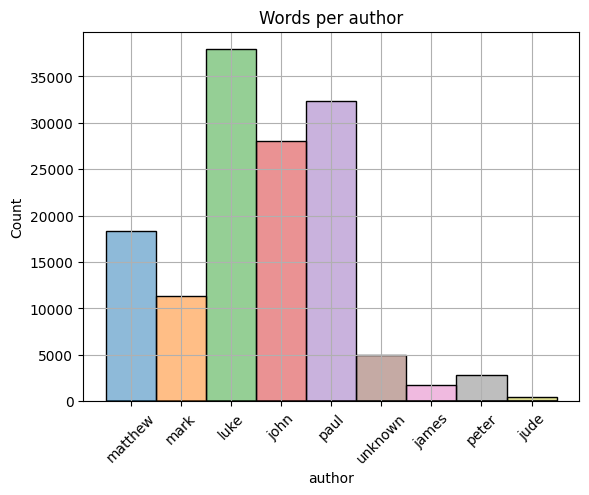

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(df, x="author", hue="author", legend=False)
plt.grid()
plt.title("Words per author")
plt.xticks(rotation=45)
plt.show()

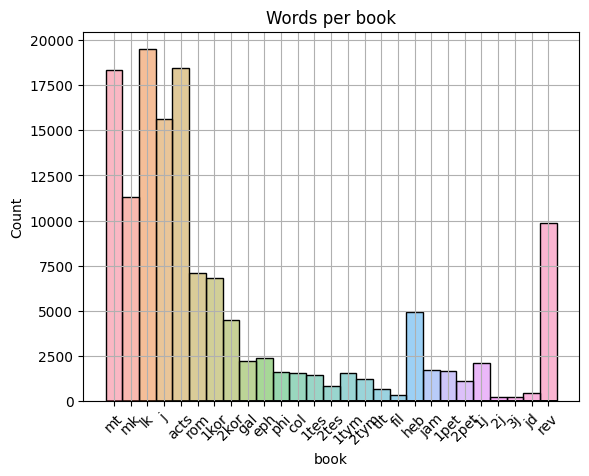

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.histplot(df, x="book", hue="book", legend=False)
plt.grid()
plt.title("Words per book")
plt.xticks(rotation=45)
plt.show()

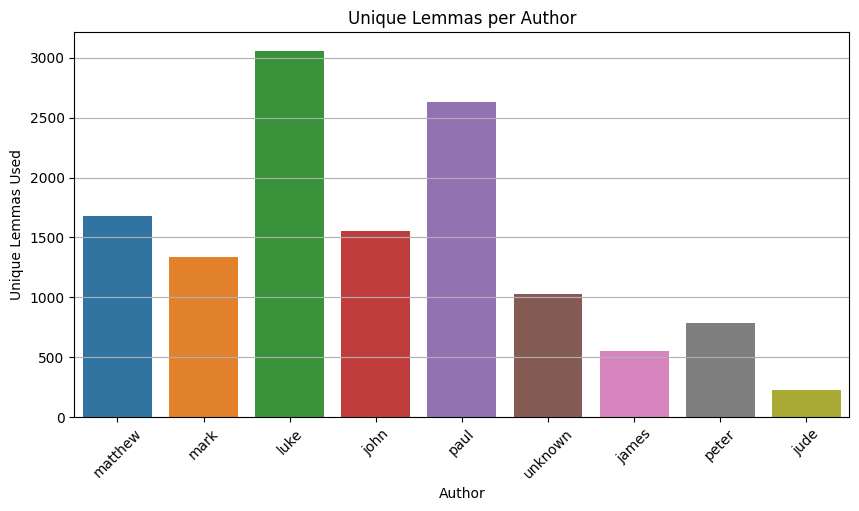

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique lemmas per author
author_lemmas = df.groupby("author", sort=False)["lemma"].nunique().reset_index()

# Plot histogram
plt.figure(figsize=(10, 5))
plt.grid()
sns.barplot(x="author", y="lemma", hue="author", data=author_lemmas)

plt.xlabel("Author")
plt.ylabel("Unique Lemmas Used")
plt.title("Unique Lemmas per Author")
plt.xticks(rotation=45)

plt.show()


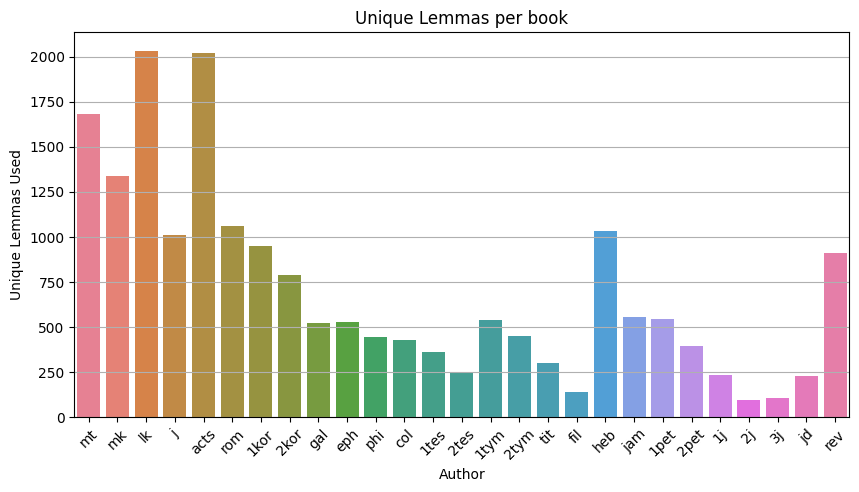

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique lemmas per book
author_lemmas = df.groupby("book", sort=False)["lemma"].nunique().reset_index()

# Plot histogram
plt.figure(figsize=(10, 5))
plt.grid()
sns.barplot(x="book", y="lemma", hue="book", data=author_lemmas)

plt.xlabel("Author")
plt.ylabel("Unique Lemmas Used")
plt.title("Unique Lemmas per book")
plt.xticks(rotation=45)

plt.show()

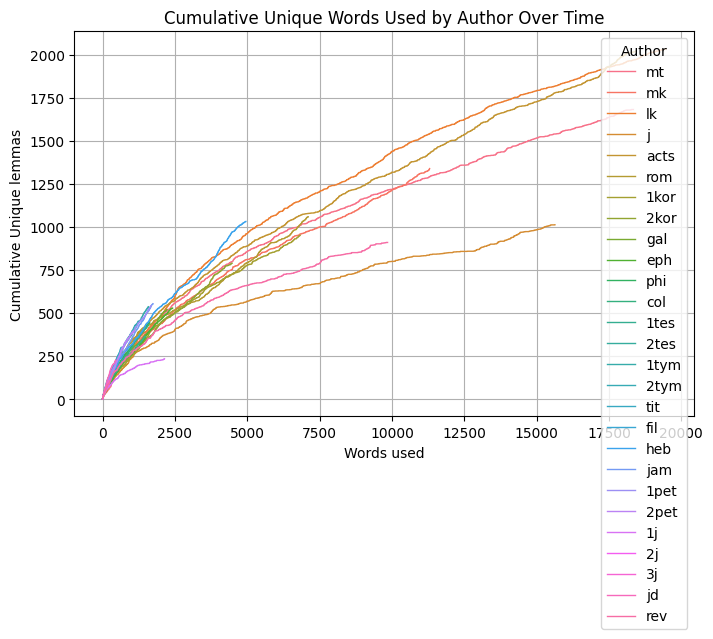

In [7]:
df["b_pos"] = df.groupby("book", sort=False).cumcount() + 1


df["b_unq"] = ~df.duplicated(subset = ["book", "lemma"])
df["b_unq"] = df.groupby("book", sort=False)["b_unq"].cumsum()

# Plot the progression
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="b_pos", y="b_unq", hue="book", lw=1)

plt.xlabel("Words used")
plt.ylabel("Cumulative Unique lemmas")
plt.title("Cumulative Unique Words Used by Author Over Time")
plt.legend(title="Author")
plt.grid()
plt.show()


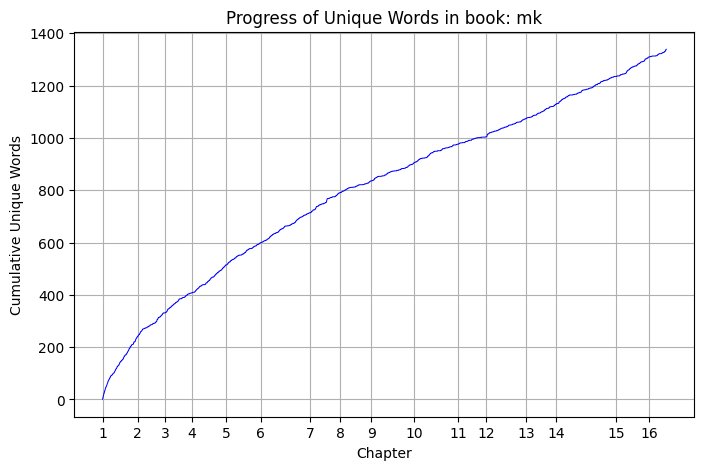

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

book = "mk"

book_df = df[df["book"] == book].copy()

book_df["b_pos"] = range(1, len(book_df) + 1)

book_df["b_unq"] = ~book_df.duplicated(subset=["lemma"])
book_df["b_unq"] = book_df["b_unq"].cumsum()

chapter_positions = book_df.groupby("chapter")["b_pos"].first()

plt.figure(figsize=(8, 5))
sns.lineplot(data=book_df, x="b_pos", y="b_unq", color="b", linewidth=0.7)

plt.xticks(ticks=chapter_positions, labels=chapter_positions.index)

plt.xlabel("Chapter")
plt.ylabel("Cumulative Unique Words")
plt.title(f"Progress of Unique Words in book: {book}")
plt.grid()
plt.show()


In [18]:
from collections import Counter

n=2
ngram_list = []

# Process each book and author separately
for (book, author), group in df.groupby(["book", "author"], sort=False):
    words = group["word"].tolist()
    
    # Create n-grams using sliding window
    ngrams = [" ".join(words[i:i+n]) for i in range(len(words) - n + 1)]
    
    # Count n-gram occurrences in this book
    book_ngram_counts = Counter(ngrams)
    total_ngrams_in_book = sum(book_ngram_counts.values())  # Total n-grams in book

    # Store results
    for ngram, count in book_ngram_counts.items():
        ngram_list.append({
            "ngram": ngram,
            "author": author,
            "book": book,
            "count_in_book": count,
            "total_ngrams_in_book": total_ngrams_in_book  # Store total for normalization
        })

# Convert to DataFrame
ngram_df = pd.DataFrame(ngram_list)

# Compute author-level counts
author_ngram_counts = ngram_df.groupby(["author", "ngram"])["count_in_book"].sum().reset_index()
author_ngram_counts.rename(columns={"count_in_book": "count_for_author"}, inplace=True)

# Compute total n-grams per author
author_total_ngrams = ngram_df.groupby("author")["count_in_book"].sum().to_dict()

# Merge author-level counts into main DataFrame
ngram_df = ngram_df.merge(author_ngram_counts, on=["author", "ngram"], how="left")

# Add total n-grams per author
ngram_df["total_ngrams_for_author"] = ngram_df["author"].map(author_total_ngrams)

# Compute frequencies normalized by n-gram count
ngram_df["freq_in_book"] = ngram_df["count_in_book"] / ngram_df["total_ngrams_in_book"]
ngram_df["freq_for_author"] = ngram_df["count_for_author"] / ngram_df["total_ngrams_for_author"]

ngram_df[ngram_df["book"] == "rom"].sort_values("freq_for_author", ascending=False)

,ngram,author,book,count_in_book,total_ngrams_in_book,count_for_author,total_ngrams_for_author,freq_in_book,freq_for_author
58830,του Θεου,paul,rom,42,7110,160,32395,0.005907,0.004939
58805,εν τω,paul,rom,28,7110,96,32395,0.003938,0.002963
58801,ο Θεος,paul,rom,25,7110,91,32395,0.003516,0.002809
59103,εν τη,paul,rom,15,7110,83,32395,0.002110,0.002562
58731,του Κυριου,paul,rom,9,7110,75,32395,0.001266,0.002315
...,...,...,...,...,...,...,...,...,...
61488,οτι τοις,paul,rom,1,7110,1,32395,0.000141,0.000031
59510,περιτομη σου,paul,rom,1,7110,1,32395,0.000141,0.000031
61490,αγαπωσιν τον,paul,rom,1,7110,1,32395,0.000141,0.000031
61491,Θεον παντα,paul,rom,1,7110,1,32395,0.000141,0.000031
